# Analysis for fires in Sentinel-3 images
This notebook analyses fires in sentinel-3 images. This should motivate the usage of Sentinel-3 images in detecting fires.

See 'Implementing an Ensemble Convolutional Neural Network on
Sentinel-1 Synthetic Aperture Radar data and Sentinel-3 Radiometric
data for the detecting of forest fires' for more information.
#### Content
- loading Sentinel-3 image from the 23th of July 2018
- displaying image
- finding boxes and a line to analyse.
- analysing the line
- analysing the boxes (briefly)




------------
Firstly, importing packages, functions and paths



In [1]:
import numpy as np
import sys
#Folder with my own functions(my_s1, my_s3 and my_modis)
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\code')
#Folder where im fetching the data from
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\data\\s3')
#my functions
import my_s3 as s3
import my_modis as md
import my_tools as tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.ndimage
from collections import deque
from bisect import insort, bisect_left
from itertools import islice


def s3_plot_hist(images):
    """
    plotting histograms of list of images. Using a constant false alarm rate of 1 and 99 % respecttivly..
    
    kristian
    """
    
    for i in range(len(images)):
        img_cfar = images[i][(images[i]>np.quantile(images[i], 0.01)) &  (images[0]<np.quantile(images[i], 0.99))]
        #Plotting 
        hist_cfar,bins_cfar = np.histogram((img_cfar).ravel(),bins=51)
        width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
        center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
        plt.bar(center_cfar, hist_cfar, align='center', width=width_cfar)
        plt.title('Historgram')
        plt.xlabel("Intensity", fontsize=16)  
        plt.ylabel("Amout of pixels", fontsize=16)
        plt.xticks(fontsize=14)  
        plt.yticks(fontsize=14)

    plt.show()
    return None


from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size):
    """
    a simple adaptive lee filter, see the authors report on speckle filtering (2017)
    """
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

def running_mean(x, N):
    """
    calculating runnin mean of a vector. Used for analysis a line..
    """
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N


def running_median(img, size):
    """
    calculating runnin median of a vector. Used for analysis a line..
    """
    img = iter(img)
    d = deque()
    s = []
    result = []
    for item in islice(img, size):
        d.append(item)
        insort(s, item)
        result.append(s[len(d)//2])
    m = size // 2
    for item in img:
        old = d.popleft()
        d.append(item)
        del s[bisect_left(s, old)]
        insort(s, item)
        result.append(s[m])
    return result

### Illustrating location.

![title](23_juli_shape.png)

###  Loading image
-----------------------


Firstly loading an image. The image loaded is taken from the Sentinel-3 satellite on 23th of July 2018 above the area of Ljusdal where the largest wildfire of 2018 happend. This corresponds to the image shown above.




### Displaying images

In [2]:
#the folder where the s1 images are located.
folder_path = "C:\\Users\krist\Documents\Syntese\data\s3\Analyse_23"
#getting all files with extention .tif.
img_paths = tools.file_paths(folder_path,verbose=1,file_type='tif')


there are: 5  . tif  files in folder



As seen from the output of the function, see below (displayed since verbose=1), where are 5 .tif files in the folder. Opening one of them.

Only loading 1 image. Loading all the bands in it.

In [4]:
s3_img,s3_raster,s3_extend, s3_names, s3_extra = s3.get_img([img_paths[1]],data_type='ENVI')

Displaying the image, the boxes and the line as used for the analysis.. See the report for more details.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


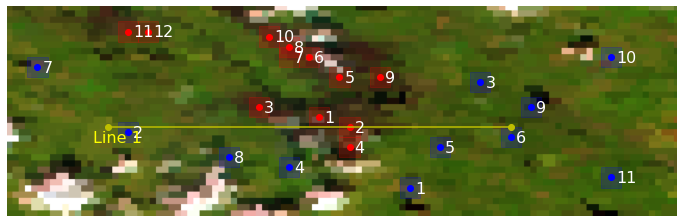

In [5]:
name = 'Sentinel_3_analysys_line_boxes.png'
#using the tools.colour_img to display as colour image. Using the tools.img_stretch to stech image for illustraiton.
nadir_false_colour_RGB = tools.color_img(tools.img_stretch(s3_img[6],0,255),tools.img_stretch(s3_img[4],0,255),tools.img_stretch(s3_img[3],0,255))
fig, axs = plt.subplots(figsize=(12,12), facecolor='w', edgecolor='k') 
axs.imshow(nadir_false_colour_RGB)
plt.xlabel('Longitude [deg]', fontsize=18)
plt.ylabel('latitude [deg]', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#fire coordinates(scatter) for illustration
plt.scatter(3100,1100,c='r')
plt.scatter(3300,700,c='r')
plt.scatter(3400,1200,c='r')
plt.scatter(2500,1000,c='r')
plt.scatter(3400,1400,c='r')
plt.scatter(3000,500,c='r')
plt.scatter(2800,400,c='r')
plt.scatter(3700,700,c='r')
plt.scatter(2600,300,c='r')
plt.scatter(1200,250,c='r')
plt.scatter(1400,250,c='r')

#no fire coordinates (scatter) for illustration
plt.scatter(4000,1800,c='b')
plt.scatter(1200,1250,c='b')
plt.scatter(4700,750,c='b')
plt.scatter(2800,1600,c='b')
plt.scatter(4300,1400,c='b')
plt.scatter(5000,1300,c='b')
plt.scatter(300,600,c='b')
plt.scatter(2200,1500,c='b')
plt.scatter(5200,1000,c='b')
plt.scatter(6000,500,c='b')
plt.scatter(6000,1700,c='b')

#defining each scatter as done above is super ineffecient, but whatever. It worked for so few points.
fire_coord=[]
fire_coord.append([1000,1200,3000,3200])
fire_coord.append([1100,1300,3300,3500])
fire_coord.append([900,1100,2400,2600])
fire_coord.append([1300,1500,3300,3500])
fire_coord.append([600,800,3200,3400])
fire_coord.append([400,600,2900,3100])
fire_coord.append([400,600,2700,2900])
fire_coord.append([300,500,2700,2900])
fire_coord.append([600,800,3600,3800])
fire_coord.append([200,400,2500,2700])
fire_coord.append([150,350,1100,1300])
fire_coord.append([150,350,1300,1500])
no_fire_coord=[]
no_fire_coord.append([1700,1900,3900,4100])
no_fire_coord.append([1150,1350,1100,1300])
no_fire_coord.append([650,850,4600,4800])
no_fire_coord.append([1500,1700,2700,2900])
no_fire_coord.append([1300,1500,4200,4400])
no_fire_coord.append([1200,1400,4900,5100])
no_fire_coord.append([500,700,200,300])
no_fire_coord.append([1400,1600,2100,2300])
no_fire_coord.append([900,1100,5100,5300])
no_fire_coord.append([400,600,5900,6100])
no_fire_coord.append([1600,1800,5900,6100])

#now, making coordinate set into arrays.
fire_box_s3 = []
for i in range(len(fire_coord)):
    coord = fire_coord[i]
    #img = (np.stack((s3_img[0][coord[0]:coord[1],coord[2]:coord[3]],s3_img[1][coord[0]:coord[1],coord[2]:coord[3]],s3_img[2][coord[0]:coord[1],coord[2]:coord[3]],s3_img[3][coord[0]:coord[1],coord[2]:coord[3]],s3_img[4][coord[0]:coord[1],coord[2]:coord[3]],s3_img[5][coord[0]:coord[1],coord[2]:coord[3]],s3_img[6][coord[0]:coord[1],coord[2]:coord[3]],s3_img[7][coord[0]:coord[1],coord[2]:coord[3]],s3_img[8][coord[0]:coord[1],coord[2]:coord[3]],s3_img[9][coord[0]:coord[1],coord[2]:coord[3]],s3_img[10][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    img = (np.stack((s3_img[0][coord[0]:coord[1],coord[2]:coord[3]],s3_img[1][coord[0]:coord[1],coord[2]:coord[3]],s3_img[2][coord[0]:coord[1],coord[2]:coord[3]],s3_img[3][coord[0]:coord[1],coord[2]:coord[3]],s3_img[4][coord[0]:coord[1],coord[2]:coord[3]],s3_img[6][coord[0]:coord[1],coord[2]:coord[3]],s3_img[7][coord[0]:coord[1],coord[2]:coord[3]],s3_img[9][coord[0]:coord[1],coord[2]:coord[3]],s3_img[10][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    
    fire_box_s3.append(img)

no_fire_box_s3 = []
for i in range(len(no_fire_coord)):
    coord = no_fire_coord[i]
    #img = (np.stack((s3_img[0][coord[0]:coord[1],coord[2]:coord[3]],s3_img[1][coord[0]:coord[1],coord[2]:coord[3]],s3_img[2][coord[0]:coord[1],coord[2]:coord[3]],s3_img[3][coord[0]:coord[1],coord[2]:coord[3]],s3_img[4][coord[0]:coord[1],coord[2]:coord[3]],s3_img[5][coord[0]:coord[1],coord[2]:coord[3]],s3_img[6][coord[0]:coord[1],coord[2]:coord[3]],s3_img[7][coord[0]:coord[1],coord[2]:coord[3]],s3_img[8][coord[0]:coord[1],coord[2]:coord[3]],s3_img[9][coord[0]:coord[1],coord[2]:coord[3]],s3_img[10][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    img = (np.stack((s3_img[0][coord[0]:coord[1],coord[2]:coord[3]],s3_img[1][coord[0]:coord[1],coord[2]:coord[3]],s3_img[2][coord[0]:coord[1],coord[2]:coord[3]],s3_img[3][coord[0]:coord[1],coord[2]:coord[3]],s3_img[4][coord[0]:coord[1],coord[2]:coord[3]],s3_img[6][coord[0]:coord[1],coord[2]:coord[3]],s3_img[7][coord[0]:coord[1],coord[2]:coord[3]],s3_img[9][coord[0]:coord[1],coord[2]:coord[3]],s3_img[10][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    
    no_fire_box_s3.append(img)
#
 

##showing boxes onto the rgb image.
for i in range(len(fire_coord)):
    rect = plt.Rectangle((fire_coord[i][2],fire_coord[i][0]), 200, 200,color='red', alpha=0.2)
    axs.add_patch(rect)
    axs.annotate(str(i+1), (fire_coord[i][2]+150, fire_coord[i][0]+150),color='white', size=16)
    
for i in range(len(no_fire_coord)):
    rect2 = plt.Rectangle((no_fire_coord[i][2],no_fire_coord[i][0]), 200, 200,color='blue', alpha=0.2)
    axs.add_patch(rect2)
    axs.annotate(str(i+1), (no_fire_coord[i][2]+150, no_fire_coord[i][0]+150),color='white', size=16)
        
#making a line to add.
x0_2, y0_2 = 1000, 1200 
x1_2, y1_2 = 5000, 1200
num = x1_2-x0_2

x_2, y_2 = np.linspace(x0_2, x1_2, num), np.linspace(y0_2, y1_2, num)
#zi = images[1][x.astype(np.int), y.astype(np.int)]
line_values = []
#getting line values for each band. getting the image values for the line.
for k in range(len(s3_img)):
    line_values.append(scipy.ndimage.map_coordinates(s3_img[k], np.vstack((y_2,x_2))))
#plotting line.
axs.annotate('Line 1', (x0_2-150, y0_2+150),color='yellow', size=16)
#axes.annotate('Line 2', (x0_2-150, y0_2+150),color='white', size=16)
plt.plot([x0_2, x1_2], [y0_2, y1_2], 'yo-', alpha=1)
plt.axis('off')
plt.savefig(name, bbox_inches='tight', dpi=400)
plt.show()


Severeal areas of interest have been defined for analysing Sentinel-3's forest fire detection capabilities. The blue boxes, each with a size of 200x200 pixels, are areas without fires. The red boxes are areas with fires. Moreover, Line 1 starts in a region without any fires, goes through a region with fires, and end in a region without any fires. Line 1 can hence be used to see the spatial change within the two regions. 


In the false-colored image above, the red/brown areas, are areas with fires. See e.g. The first figure, with shapefiles of the fire. The green areas are vegetated areas without fires. The white areas are clouds. The grey/white areas close to the fire are either smoke, clouds or a mix hereoff.


In the figure below, we see the pixel values for Line 1 for each Senntinel-3 band.
#### Looking at Line 1!

Line 1 goes from a non-fire area, thorugh a fire area, ending up in a non fire area. Now, we aer analysing this line to see if there are any trends.

--------------------------------------

### The line, and median

Below, we are plotting the values in different bands.

In [8]:
#number of bands
print(len(s3_img))
print(len(line_values))
#should be 11.

11
11


Below is illustrated the lines values for band F1,F2 S3, S5 and S8. These are th 5 bands used in the report, more info on that in 'Implementing an Ensemble Convolutional Neural Network on Sentinel-1 Synthetic Aperture Radar data and Sentinel-3 Radiometric data for the detecting of forest fires'.

Here, we can see that in particular F1, F2 and S8 have a strong signal(see the axis) and that S3 and S5 does not have a signal.
As stated in the theory, S3 is a band that is used to detect false positive, and solar glipse. 
This band should not be affected that much by eihter solar glipse or small fire. Looking in the figure, wee can see a sharp change where we expeced a fire. This is a good indication of the strengts of the S3 band.

The S5 band has only a small signal which is suprising.


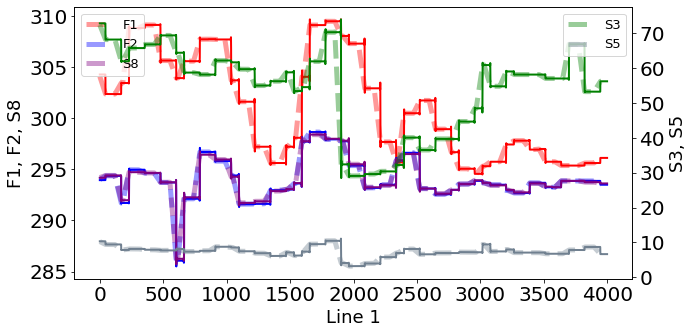

In [10]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.cm as cm
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
#band_names = ['F1','F2','S7','S8','S9','S1','S2','S3','S4','S5','S6']
band_names = ['F1','F2','S1','S2','S3','S4','S5','S6','S7','S8','S9']
color = ['r','b','m','c','g','k','slategray','pink','orange','purple','teal']
plt.xlabel('Line 1', fontsize=18)
plt.ylabel('F1, F2, S8', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax2=axs.twinx()

for i in range(len(s3_img)):
    if band_names[i]=='F1' or band_names[i]=='F2' or band_names[i]=='S8':
        axs.plot(running_mean(line_values[i]**1,50), linewidth=5, color= color[i],alpha=0.4,label=band_names[i],linestyle='--')
        axs.plot(running_mean(line_values[i]**1,1), linewidth=2, color= color[i], alpha=1)
    if band_names[i]=='S3' or band_names[i]=='S5':
        ax2.plot(running_mean(line_values[i]**1,50), linewidth=5, color= color[i],alpha=0.4,label=band_names[i],linestyle='--')
        ax2.plot(running_mean(line_values[i]**1,1), linewidth=2, color= color[i], alpha=1)
        

name ='s3_analysis_median_200.png'
#axs = plt.gca()
plt.xlabel('Line 1', fontsize=18)
plt.ylabel('S3, S5', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend()
axs.legend(loc  = 'upper left',fontsize =13)
ax2.legend(loc  = 'upper right',fontsize =13)
#plt.grid()
plt.savefig('s3_analyse_line1_23_running_mean_5_bands.png', bbox_inches='tight', dpi=200)
plt.show()

Below are all the bands illustrated. Looking at the legends, we see that F1, F2, S7, S8 and S9 have the large signals, this is what we expected.  F1 and F2 are the fire bands. S7, S8 and S9 are the brightness bands where as S1, S2, S3, S4, S5 and S6 are all the radiance bands. Radiance are dependant on the solid angle, whereas brightness is not. It should thus be smaller in pixel values. Still, even if it is smaller we can e.g. on the S1, S2 and S3 see the peaks at the fire locations.


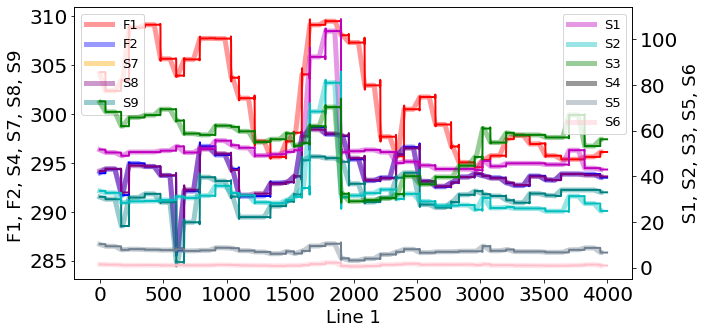

In [13]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.cm as cm
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
#band_names = ['F1','F2','S1','S8','S9','S1','S2','S3','S4','S5','S6']
band_names = ['F1','F2','S1','S2','S3','S4','S5','S6','S7','S8','S9']
color = ['r','b','m','c','g','k','slategray','pink','orange','purple','teal']
plt.xlabel('Line 1', fontsize=18)
plt.ylabel('F1, F2, S4, S7, S8, S9 ', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax2=axs.twinx()
for i in range(len(s3_img)):
    if band_names[i]=='F1' or band_names[i]=='F2' or band_names[i]=='S9' or band_names[i]=='S8' or band_names[i]=='S7':
        
        axs.plot(running_mean(line_values[i]**1,50), linewidth=5, color= color[i],alpha=0.4,label=band_names[i])
        axs.plot(running_mean(line_values[i]**1,1), linewidth=2, color= color[i], alpha=1)
    else:
        ax2.plot(running_mean(line_values[i]**1,50), linewidth=5,color= color[i], alpha=0.4,label=band_names[i])
        ax2.plot(running_mean(line_values[i]**1,1), linewidth=2, color= color[i],alpha=1)
        

name ='s3_analysis_median_200.png'
#axs = plt.gca()
plt.xlabel('Line 1', fontsize=18)
plt.ylabel(' S1, S2, S3, S5, S6 ', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.legend()
axs.legend(loc  = 'upper left',fontsize =13)
ax2.legend(loc  = 'upper right',fontsize =13)
#plt.grid()
plt.savefig('s3_analyse_line1_23_running_mean.png', bbox_inches='tight', dpi=200)
plt.show()

To better illustrate each individual band, they are all illustrated below. Here, it is possible to see the difference in the bands. Some bands show the fire, whereas some does not.

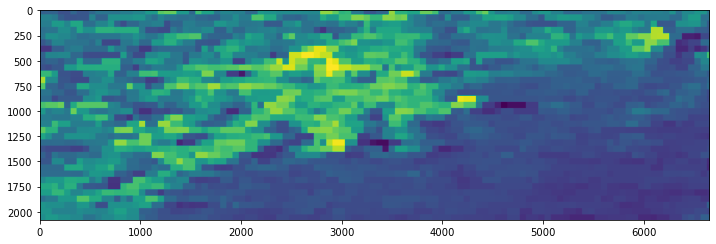

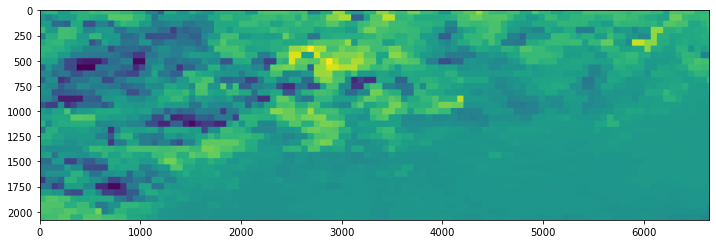

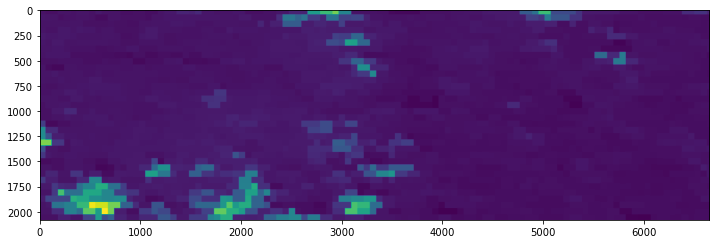

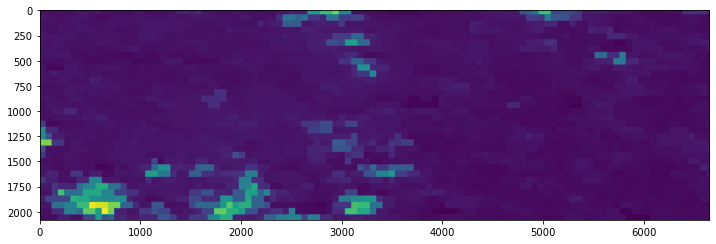

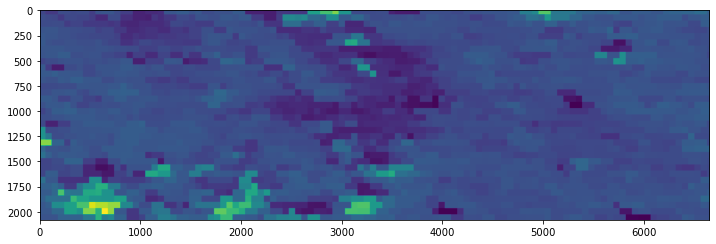

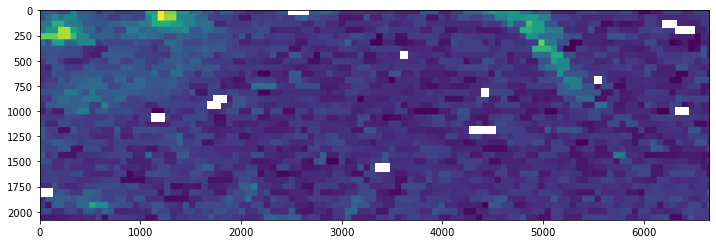

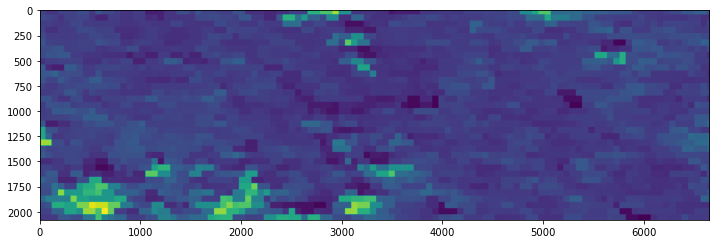

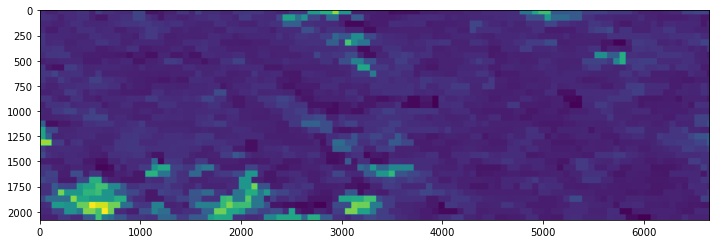

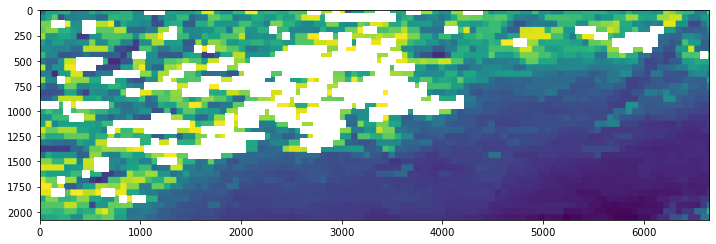

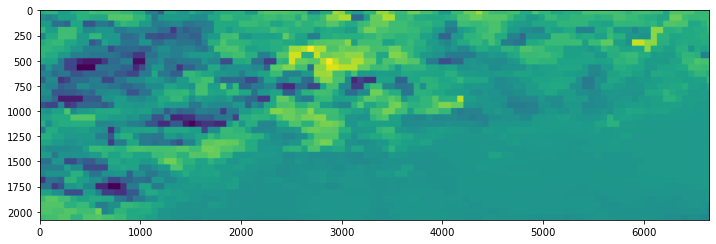

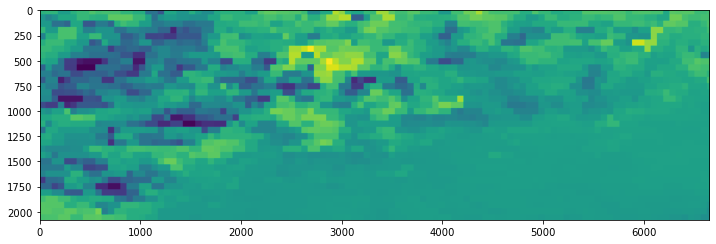

In [19]:
for i in range(len(s3_img)):
    fig, axs = plt.subplots(figsize=(12,12), facecolor='w', edgecolor='k') 
    axs.imshow(s3_img[i])

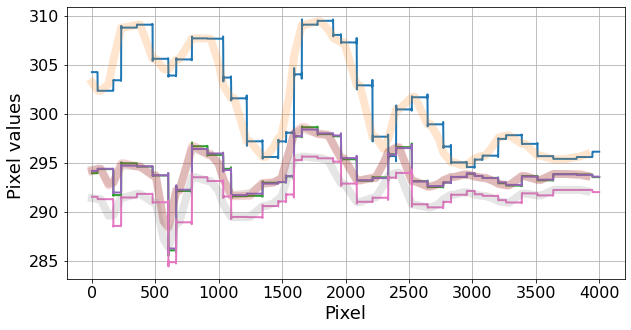

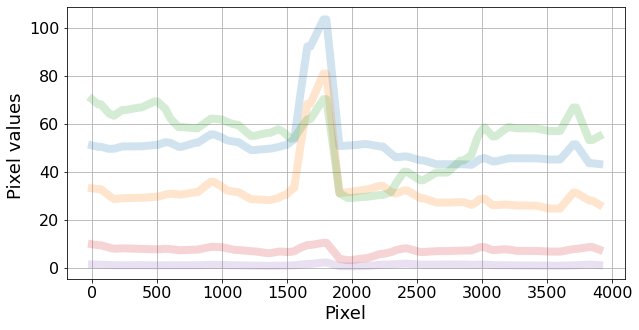

In [63]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
line_part = [line_values[1],line_values[8],line_values[9],line_values[8]]
line_part_h = [line_values[0],line_values[1],line_values[9],line_values[10]]
line_part_l = [line_values[2],line_values[3],line_values[4],line_values[6],line_values[7]]

for i in range(len(line_part_h)):
    plt.plot((line_part_h[i]), linewidth=2, alpha=1)
    plt.plot(running_mean(line_part_h[i],100), linewidth=8, alpha=0.2)
    #plt.plot(running_median(line_part_h[i],100), linewidth=8, alpha=0.2)

name ='s3_analysis_median_200.png'
axs = plt.gca()
plt.xlabel('Pixel', fontsize=18)
plt.ylabel('Pixel values ', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend({'F1','F2','S1','S2','S3','S4','S5','S6','S7','S8','S9'},loc="lower right")
plt.grid()
#plt.savefig(name, bbox_inches='tight', dpi=600)
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

for i in range(len(line_part_l)):
    #plt.plot((line_part_l[i]), linewidth=2, alpha=1)
    plt.plot(running_mean(line_part_l[i],100), linewidth=8, alpha=0.2)
axs = plt.gca()
plt.xlabel('Pixel', fontsize=18)
plt.ylabel('Pixel values ', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend({'F1','F2','S1','S2','S3','S4','S5','S6','S7','S8','S9'},loc="lower right")
plt.grid()
#plt.savefig(name, bbox_inches='tight', dpi=600)
plt.show()


Now, a STRONG running mean is made (250), this is just for illsutrative purposes. We see that S3 and S5 do have a signal on the fire.

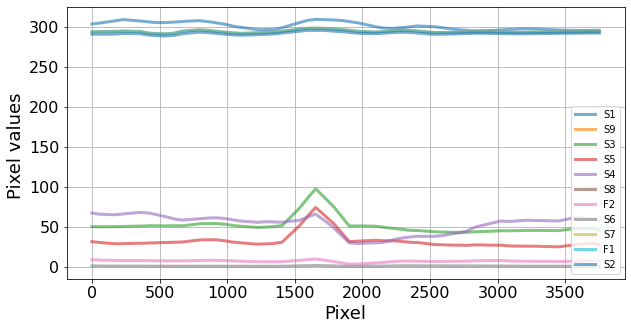

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
for i in range(len(s3_img)):
    plt.plot(running_mean(line_values[i],250), linewidth=3, alpha=0.6)

name ='s3_analysis_mean_200.png'
axs = plt.gca()
plt.xlabel('Pixel', fontsize=18)
plt.ylabel('Pixel values ', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend({'F1','F2','S1','S2','S3','S4','S5','S6','S7','S8','S9'},loc="lower right")
plt.grid()
#plt.savefig(name, bbox_inches='tight', dpi=600)
plt.show()


This concluded a quick analysis of the line. 


### Looking at entire picture
No, we will take the mean of the entire picuture

--------------



Getting means of no fire

In [22]:
mean_all = np.zeros(s3_img[0].shape)
mean_5_bands = np.zeros(s3_img[0].shape)
#['F1','F2','S7','S8','S9','S1','S2','S3','S4','S5','S6'] = 0,1,3,7,8

In [25]:
for i in range(mean_all.shape[0]):
    for j in range(mean_all.shape[1]):
        mean_all[i,j] = np.nanmean([s3_img[0][i,j],s3_img[1][i,j],s3_img[2][i,j],s3_img[3][i,j],s3_img[4][i,j],s3_img[5][i,j],s3_img[6][i,j],s3_img[7][i,j],s3_img[8][i,j],s3_img[9][i,j],s3_img[10][i,j]])
        mean_5_bands[i,j] = np.nanmean([s3_img[0][i,j],s3_img[1][i,j],s3_img[3][i,j],s3_img[7][i,j],s3_img[8][i,j]])

First, the average is taken over all the bands. Then, it is taken over the 5 bands used. It is possible to see where the fire is.

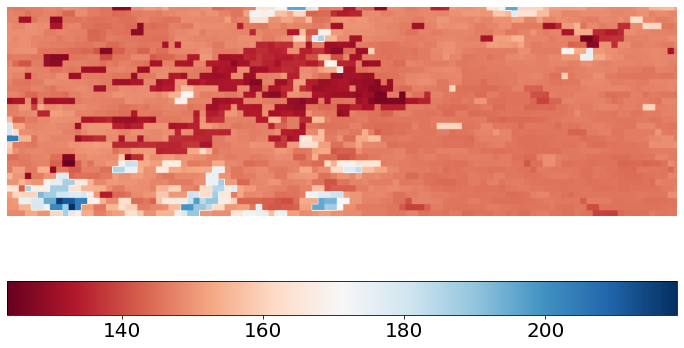

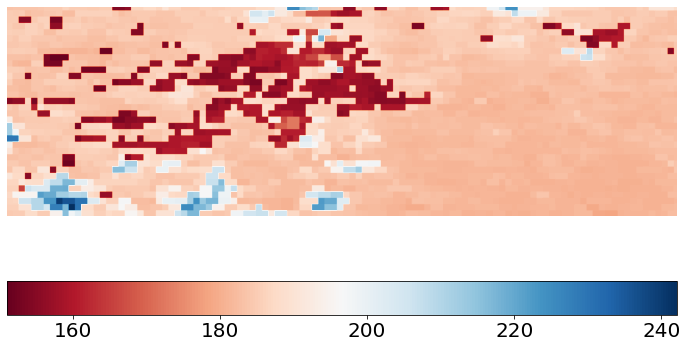

In [101]:
fig, axs = plt.subplots(figsize=(12,8), facecolor='w', edgecolor='k') 
im = axs.imshow(mean,cmap='RdBu')
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=20) 
cbar.ax.tick_params(labelsize=20) 
plt.axis('off')
plt.savefig('avg_all.png',bbox_inches='tight', transparent=True)
plt.show()


fig, axs = plt.subplots(figsize=(12,8), facecolor='w', edgecolor='k') 
im = axs.imshow(mean_5_bands,cmap='RdBu')
cbar = plt.colorbar(im, orientation='horizontal')
cbar.ax.tick_params(labelsize=20) 
cbar.ax.tick_params(labelsize=20) 
plt.axis('off')
plt.savefig('avg_5_bands.png',bbox_inches='tight', transparent=True)
plt.show()

Now, we will look a bit into the boxes.

# Boxes
Getting the boxes.

In [44]:

mean_fire_box_s3 = []
mean_fire_box_s3_5_bands = []
for i in range(len(fire_coord)):
    coord = fire_coord[i]
    img = mean_all[coord[0]:coord[1],coord[2]:coord[3]]
    mean_fire_box_s3.append(img)
    img = mean_5_bands[coord[0]:coord[1],coord[2]:coord[3]]
    mean_fire_box_s3_5_bands.append(img)
    #img = (np.stack((mean[0][coord[0]:coord[1],coord[2]:coord[3]],mean[1][coord[0]:coord[1],coord[2]:coord[3]],mean[4][coord[0]:coord[1],coord[2]:coord[3]],mean[6][coord[0]:coord[1],coord[2]:coord[3]],mean[9][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    #mean_fire_box_s3_5_bands.append(img)

mean_no_fire_box_s3 = []
mean_no_fire_box_s3_5_bands = []
for i in range(len(no_fire_coord)):
    coord = no_fire_coord[i]
    img = mean_all[coord[0]:coord[1],coord[2]:coord[3]]
    mean_no_fire_box_s3.append(img)
    img = mean_5_bands[coord[0]:coord[1],coord[2]:coord[3]]
    mean_no_fire_box_s3_5_bands.append(img)
#

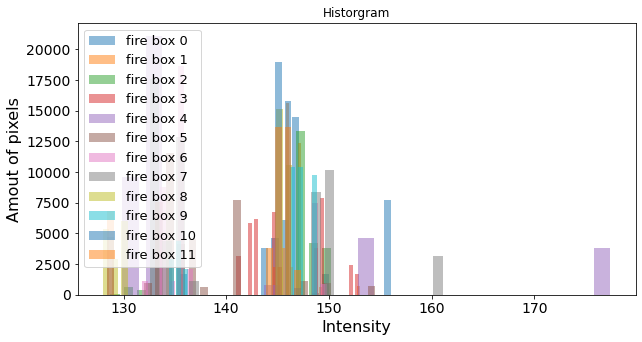

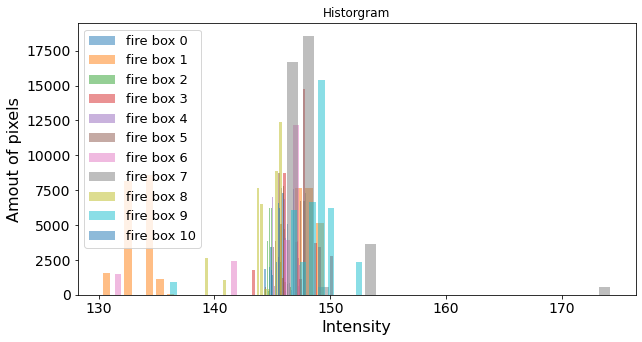

In [45]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

for i in range(len(mean_fire_box_s3)):
    #img_cfar = imagesss[i][(imagesss[i]>np.quantile(imagesss[i], 0.01)) &  (imagesss[0]<np.quantile(imagesss[i], 0.99))]
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((mean_fire_box_s3[i][:,:]).ravel(),bins=21)
    width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
    center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
    axs.bar(center_cfar, hist_cfar, align='center', width=width_cfar, alpha=0.5,label='fire box '+str(i))
    plt.title('Historgram')
    plt.xlabel("Intensity", fontsize=16)  
    plt.ylabel("Amout of pixels", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','average of box 2,3,4,6'})
axs.legend(loc  = 'upper left',fontsize =13)
plt.show()



fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))


for i in range(len(mean_no_fire_box_s3)):
    #img_cfar = imagesss[i][(imagesss[i]>np.quantile(imagesss[i], 0.01)) &  (imagesss[0]<np.quantile(imagesss[i], 0.99))]
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((mean_no_fire_box_s3[i][:,:]).ravel(),bins=21)
    width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
    center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
    axs.bar(center_cfar, hist_cfar, align='center', width=width_cfar, alpha=0.5,label='fire box '+str(i))
    plt.title('Historgram')
    plt.xlabel("Intensity", fontsize=16)  
    plt.ylabel("Amout of pixels", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','average of box 2,3,4,6'})

axs.legend(loc  = 'upper left',fontsize =13)
plt.show()

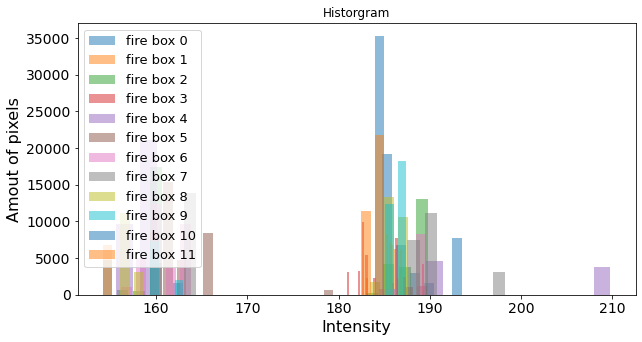

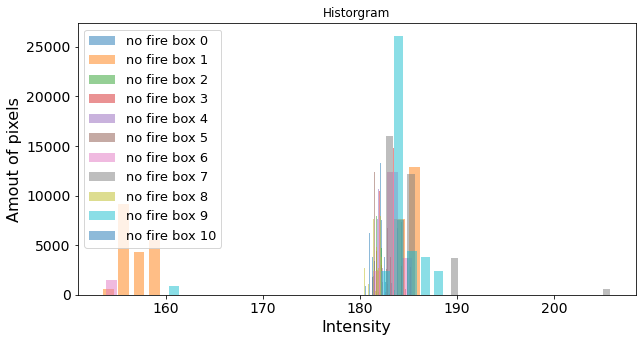

In [48]:

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

for i in range(len(mean_fire_box_s3_5_bands)):
    #img_cfar = imagesss[i][(imagesss[i]>np.quantile(imagesss[i], 0.01)) &  (imagesss[0]<np.quantile(imagesss[i], 0.99))]
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((mean_fire_box_s3_5_bands[i][:,:]).ravel(),bins=21)
    width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
    center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
    axs.bar(center_cfar, hist_cfar, align='center', width=width_cfar, alpha=0.5,label='fire box '+str(i))
    plt.title('Historgram')
    plt.xlabel("Intensity", fontsize=16)  
    plt.ylabel("Amout of pixels", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','average of box 2,3,4,6'})
axs.legend(loc  = 'upper left',fontsize =13)
plt.show()



fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))


for i in range(0,len(mean_no_fire_box_s3_5_bands)):
#for i in range(0,4):
    #img_cfar = imagesss[i][(imagesss[i]>np.quantile(imagesss[i], 0.01)) &  (imagesss[0]<np.quantile(imagesss[i], 0.99))]
    #Plotting 
    hist_cfar,bins_cfar = np.histogram((mean_no_fire_box_s3_5_bands[i][:,:]).ravel(),bins=21)
    width_cfar = 0.7 * (bins_cfar[1] - bins_cfar[0])
    center_cfar = (bins_cfar[:-1] + bins_cfar[1:]) / 2     
    axs.bar(center_cfar, hist_cfar, align='center', width=width_cfar, alpha=0.5,label='no fire box '+str(i))
    plt.title('Historgram')
    plt.xlabel("Intensity", fontsize=16)  
    plt.ylabel("Amout of pixels", fontsize=16)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
plt.legend({'Box 1','Box 5','average of box 2,3,4,6'})

axs.legend(loc  = 'upper left',fontsize =13)
plt.show()

Hard to say anyting. just look at the line. More analysis could be made, but is not neccesary for the project.